<a href="http://www.stfc.ac.uk/"> <img src="../../img/STFCLargeColour.jpg" width="50%" align="left"/></a>
<a href="https://www.addopt.org/"><img src="../../img/ADDoPT-logo-MAIN-with-text.png" width="300" height="200" align="right"/></a>


# Manifold learning


You may have already come across PCA, which is a linear dimensionality reduction framework. This works by defining special rubrics to choose an interesting linear projection of the data. Whilst these can be powerful, they can often miss important nonlinear structure in the data.

Can be thought of as an attempt to generalise linear frameworks like PCA, allowing them to become sensitive to the nonlinear structure in data. Manifold learning is typically unsupervised, learning the structure of the data itself without the use of predetermined classifications.

An example of this is in available in [sklearn](http://scikit-learn.org/stable/auto_examples/manifold/plot_compare_methods.html#sphx-glr-auto-examples-manifold-plot-compare-methods-py). By reducing the dimensionality of the dataset, it is much easier to visualise any structure of the dataset.

There are a variety of algorithms available to aid in seeking lower dimensional embedding of datasets. We have applied a few to our own:

1. Isomap
2. Locally linear embedding
3. Multidimensional scaling (MDS)

MDS requires us to supply a distance matrix for our features. 

In [19]:
#import statements
import sys
sys.path.append("../lib/")
import models
import sklearn
import pandas 
import numpy as np
import matplotlib.pyplot as plt

models.hideAnswers

In [34]:
#load data for this module
training_data = pandas.read_pickle("../model_data/chembl21_drug_easy_train_desc.p")
distances = pandas.read_pickle("../model_data/chembl21_features_drug_easy_distances.p")
clusters = pandas.read_pickle("../model_data/chembl21_feature_clusters.p")
normalised_features = pandas.read_pickle("../model_data/chembl21_train_normalised_features.p")

## Perform [manifold learning](http://scikit-learn.org/stable/modules/manifold.html#manifold)

We will apply each of the manifold learning algorithms to our distance matrix. Each algorithm will plot what it believes is the structure of the dataset into 2-dimensional space. 

Features (descriptors) that group together in two dimensional space may contain a lot of shared information, and so selected features from each space may be removed.

In [35]:
from sklearn import (manifold, datasets, decomposition, ensemble,
                     discriminant_analysis, random_projection)

nn=50 #1% of the training data.

MDS = {
    'isomap':manifold.Isomap(n_neighbors=nn, n_components=2),
    'lle_standard':manifold.LocallyLinearEmbedding(n_neighbors=nn, n_components=2, method='standard'),
    #'lle_modified':manifold.LocallyLinearEmbedding(n_neighbors=nn, n_components=2, method='modified'),
    #'lle_hessian':manifold.LocallyLinearEmbedding(n_neighbors=nn, n_components=2, method='hessian'),
    #'ltsa':manifold.LocallyLinearEmbedding(n_neighbors=nn,n_components=2,method="ltsa"),
    'pca':decomposition.TruncatedSVD(n_components=2),
    'mds':manifold.MDS(n_components=2, dissimilarity='precomputed', random_state=1),
    #'spectral':manifold.SpectralEmbedding(n_components=2),
    #'tsne':manifold.TSNE(n_components=2, init='pca', random_state=0)   
}

MDSTitle = {
    'isomap':"Isomap",
    'lle_standard':"Standard Locally\nLinear Embedding",
    #'lle_modified':"Modified Locally\nLinear Embedding",
    #'lle_hessian':"Hessian Locally\nLinear Embedding",
    #'ltsa':"Local Tangent\nSpace Alignment",
    'pca':"PCA",
    'mds':"Multidimensional Scaling",
    #'spectral':"Spectral Embedding",
    #'tsne':"t-SNE"   
}

Let's look closer at [MDS](http://www.statsoft.com/Textbook/Multidimensional-Scaling).

MDS attempts to model the similarity or dissimilarity data as distances in geometric spaces. In metric MDS (as performed here), the distances between the output two points are set to be as close as possible to the similarity of the data. A good way to think of this is the data being major cities, and the MDS trying to plot them onto a map according to the distances between the cities.

Algorithm:

1. Plot a single point
2. How well do the remaining distances to other points fit the distance matrix?
3. Rearrange accordingly.

It is maximising the goodness-of-fit, or minimising lack-of-fit.

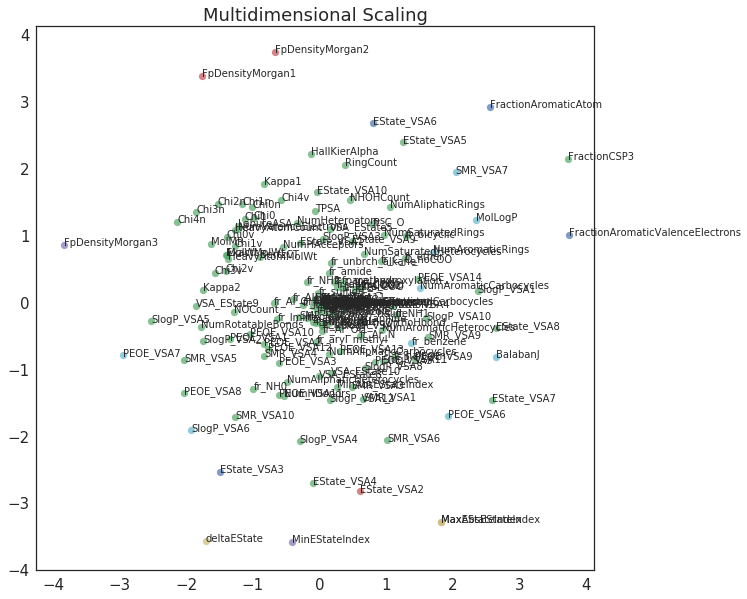

In [25]:
labels = np.array(list(clusters.Cluster))

plt.figure(figsize=(10,10))
embedding = MDS['mds'].fit_transform(distances)
X = embedding[:,0]
Y = embedding[:,1]
df = {"X" : X, "Y": Y, "Descriptor":distances.columns}
df = pandas.DataFrame(df)
for i in range(1,len(np.unique(labels))+1):
    subsDesc = df.loc[clusters.Cluster[clusters.Cluster == i].index.tolist(),"Descriptor"]
    x = df.loc[clusters.Cluster[clusters.Cluster == i].index.tolist(),"X"]
    y = df.loc[clusters.Cluster[clusters.Cluster == i].index.tolist(),"Y"]
    plt.scatter(x, y, label="Cluster %g" % (i), linewidth=0.15, alpha=0.7, s=50)
    n = 0
    for a,b in zip(x,y):
        plt.annotate(subsDesc.iloc[n], xy=(a,b), size=10)
        n = n + 1
plt.title(MDSTitle['mds'])
plt.show()


[Isomap](http://scikit-learn.org/stable/modules/manifold.html#isomap) is viewed as an extension of MDS. It has four stages:

1. Determine the $k$ nearest neighbours.
2. Construct a neighbourhood graph, where each point is connected to another if it is a $k$ nearest neighbour. The edge length is equal to the euclidean distance.
3. Compute the shortest path between two points.
4. Performs partial eigenvalue decomposition to find the lower-dimensional embedding of points so that each point has a distance to another of the shortest path.

[Locally Linear Embedding](http://scikit-learn.org/stable/modules/manifold.html#locally-linear-embedding) preserves the distances within local neighbourhoods. It also has three stages:

1. Determine the $k$ nearest neighbours.
2. Computes a set of weights for each point that best describes it as a linear combination of its neighbours.
3. Performs partial eigenvalue decomposition to find the lower-dimensional embedding of points, such that each point is still described with the same linear combination of its neighbours.

If using the modified LLE, regularisation is performed. For more information, please see the page [here](http://scikit-learn.org/stable/modules/manifold.html#locally-linear-embedding).

<div class="alert alert-warning" role="alert">
<b>Exercise</b> Perform isomap on our data. What conclusions can be made? 
Be sure to check what input is needed:
<ol>
<li>Does it need normalisation?<br>
<li>Does it need to be the distance matrix?</li></ol><br></div>

As an exploratory process, these plots allow us to visually compare the information shared between descriptors. Large clusters of descriptors are likely to give similar information, and so single features could be selected manually from these clusters.


## Questions to consider

1. Could manifold learning be used on samples in a useful way? How?

## Further reading

For more information on the topics covered here:
    
1. [Isomap](http://science.sciencemag.org/content/290/5500/2319.full)


[Up](../Welcome.ipynb)<br> [Back]() [Next](../CrossValidation.ipynb) <br>

---------------------------------------------------
Copyright STFC 2018